<a href="https://colab.research.google.com/github/produdez/diveintocode-ml/blob/main/Week%2016/ScratchDeepNeural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Last time, we created a three-layer neural network, but this time we will rewrite it into one that can easily be expanded to an arbitrary number of layers. After that, we will be able to deal with advanced functions, activation functions, initial values, and optimization methods.


By doing this from scratch, we aim to give you an idea of the inner workings of the various frameworks that we will be using.


The name should be changed from Scratch Deep Neural Network Classifier class.

In [1]:
#dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Set Prep

In [2]:
#data set
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#reshape
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
#scaling
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
#one hot encode for multiclass labels!
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
#validation split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

11501568/11490434 [==============================] - 0s 0us/step


# Mini Batch

In [3]:
#mini batch
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

# Old Prototype

In [4]:
# 3 layers prototype
from sklearn.metrics import accuracy_score

class Scratch3LayerNeural():
    def __init__(self, max_iter = 50, lr = 0.1, encoder = enc, verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.activation = sigmoid
        self.sigma = 0.01
        self.batch_size = 20 # batch size 
        self.n_features = 784 # number of features 
        self.n_nodes1 = 400 # number of first layer nodes 
        self.n_nodes2 = 200 # number of second layer nodes 
        self.n_output = 10 # number of output classes (number of nodes in the 3rd layer)

    def _init_params_and_output_container(self, prev_n_nodes, current_n_nodes):
        weight = self.sigma * np.random.randn(prev_n_nodes,current_n_nodes)
        bias = self.sigma * np.random.randn(1,current_n_nodes)
        return weight,bias
    def fit(self,X,y, X_val = None, y_val = None):
        #prepare
        self.n_features = X.shape[1]
        self.lenx = len(X)
        self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug
        #init weights,bias and z_container
        self.W1,self.B1 = self._init_params_and_output_container(n_features,self.n_nodes1)
        self.W2,self.B2 = self._init_params_and_output_container(self.n_nodes1,self.n_nodes2)
        self.W3,self.B3 = self._init_params_and_output_container(self.n_nodes2,self.n_output)
        if self.verbose:
            print('X shape: ', X.shape, 'type: ', X.dtype)
            print('Batch count: ', self.batch_count)
            print('1st layer: ', self.W1.shape, self.B1.shape)
            print('2nd layer: ', self.W2.shape, self.B2.shape)
            print('3rd layer: ', self.W3.shape, self.B3.shape)

        #train
        self.loss = np.zeros(self.epoch)
        self.accuracy = np.zeros(self.epoch)
        for i in range(self.epoch): #one full data ilteration
            if self.verbose: print('Epoch: ', i)
            self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
                if self.debug: print('Current batch: ', idx)
                #train mini_batch
                self.forward_prop(mini_X_train,mini_y_train)
                self.backward_prop(mini_X_train,mini_y_train)


            #record loss data
            Z3 = self.forward_prop(X,y,update = False)
            self.loss[i] = self.cross_entropy_error(Z3,y)
            train_pred = self.predict(X)
            self.accuracy[i]  = accuracy_score(train_pred,y)
            if self.verbose:
                print(f'Loss {i}:', self.loss[i])
                print(f'Acc {i}:', self.accuracy[i])
                
        #verbose
        if self.verbose:
            print('Final train loss:',self.loss[-1])
            print('Final train accuracy:',self.accuracy[-1])

    def forward_prop(self,X,y, update = True):
        activation = self.activation
        W1,B1 = self.W1,self.B1
        W2,B2 = self.W2,self.B2
        W3,B3 = self.W3,self.B3
        # first layer
        A1 = X@W1 + B1
        Z1= activation(A1)
        # second layer
        A2 = Z1@W2 + B2
        Z2 = activation(A2)
        #last (third) layer
        A3 = Z2@W3 + B3
        Z3 = softmax(A3)

        if update: #for training
            self.A1 = A1
            self.Z1 = Z1
            self.A2 = A2
            self.Z2 = Z2
            self.A3 = A3
            self.Z3 = Z3
        else: # for predicting
            return Z3

    def backward_prop(self,X,y):
        A1 = self.A1 
        Z1 = self.Z1 
        A2 = self.A2 
        Z2 = self.Z2 
        A3 = self.A3 
        Z3 = self.Z3 
        #third
        grad_L_A3 = 1/nb * (Z3 - y)
        grad_L_B3 = grad_L_A3.sum(axis = 0).reshape(1,-1)
        grad_L_W3 = Z2.T @ grad_L_A3
        grad_L_Z2 = grad_L_A3 @ W3.T
        #second
        grad_L_A2 = grad_L_Z2 * (1 - np.tanh(A2)** 2)
        grad_L_B2 = grad_L_A2.sum(axis = 0).reshape(1,-1)
        grad_L_W2 = Z1.T @ grad_L_A2
        grad_L_Z1 = grad_L_A2 @ W2.T
        #first
        grad_L_A1 = grad_L_Z1 * (1 - np.tanh(A1) ** 2)
        grad_L_B1 = grad_L_A1.sum(axis = 0).reshape(1,-1)
        grad_L_W1 = X.T @ grad_L_A1
        
        #new params
        lr = self.lr
        self.W1 += - lr * grad_L_W1
        self.B1 += - lr * grad_L_B1
        self.W2 += - lr * grad_L_W2
        self.B2 += - lr * grad_L_B2
        self.W3 += - lr * grad_L_W3
        self.B3 += - lr * grad_L_B3
        
    
    def cross_entropy_error(self,Z3,y):
        return (np.log(Z3) * y).sum() / (- len(Z3))

    def predict(self,X):
        y = np.zeros(X.shape[0])
        Z3  = self.forward_prop(X,y,update = False)
        return self.encoder.transform(np.argmax(Z3, axis = 1).reshape(-1,1))

# Problem 1
Classifying fully connected layer

In [5]:
class FC:
  """
  Number of nodes Fully connected layer from n_nodes1 to n_nodes2
  Parameters
  ----------
  n_nodes1 : int
    Number of nodes in the previous layer
  n_nodes2 : int
    Number of nodes in the later layer
  initializer: instance of initialization method
  optimizer: instance of optimization method
  """
  def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
      # Initialize
      self.optimizer = optimizer
      self.n_nodes1, self.n_nodes2 = n_nodes1, n_nodes2
      # Initialize self.W and self.B using the initializer method
      self.W = initializer.W(n_nodes1, n_nodes2)
      self.B = initializer.B(n_nodes2)
      pass
  def forward(self, X):
      """
      forward
      Parameters
      ----------
      X : The following forms of ndarray, shape (batch_size, n_nodes1)
          入力
      Returns
      ----------
      A : The following forms of ndarray, shape (batch_size, n_nodes2)
          output
      """        
      self.X = X
      A = X @ self.W + self.B
      return A
  def backward(self, dA):
      """
      Backward
      Parameters
      ----------
      dA : The following forms of ndarray, shape (batch_size, n_nodes2)
          Gradient flowing from behind
      Returns
      ----------
      dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
          Gradient to flow forward
      """
      # update
      self.dA = dA

      self.dZ = None #update in optimizer!
      self = self.optimizer.update(self)
      return self.dZ

# Problem 2
Classifying initialization method

In [6]:
class SimpleInitializer:
  """
  Simple initialization with Gaussian distribution
  Parameters
  ----------
  sigma : float
    Standard deviation of Gaussian distribution
  """
  def __init__(self, sigma):
    self.sigma = sigma
  def W(self, n_nodes1, n_nodes2):
    """
    Weight initialization
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    Returns
    ----------
    W :
    """
    W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
    return W
  def B(self, n_nodes2):
    """
    Bias initialization
    Parameters
    ----------
    n_nodes2 : int
      Number of nodes in the later layer
    Returns
    ----------
    B :
    """
    B = self.sigma * np.random.randn(1,n_nodes2)
    return B

# Problem 3
Classifying Optimization method

In [7]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        dA = layer.dA #this is flow from back
        X = layer.X # input to the layer (X or Z)
        W,B = layer.W, layer.B

        dB = dA.sum(axis = 0).reshape(1,-1)  
        dW = X.T @ dA
        dZ = dA @ W.T #this will flow to the front
        #update
        layer.B += - self.lr * dB
        layer.W += - self.lr * dW
        layer.dZ = dZ
        return layer

# Problem 4
Classifying Activation Function

In [8]:
# Problem 4: Classifying activation function
class ActivationFunction():
  def forward(self,A):
    pass
  def backward(self,dZ):
    pass
class Sigmoid(ActivationFunction):
  def func(self,A):
    return 1/(1+np.exp(-A))
  def forward(self,A):
    self.A = A
    return self.func(A)
  def backward(self,dZ):
    A = self.A
    dA = dZ * (1 - self.func(A))@self.func(A)
class Tanh(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
    return Z
  def backward(self,dZ):
    A = self.A
    dA = dZ * (1 - np.tanh(A) ** 2)
    return dA
  
class SoftMax(ActivationFunction):
  def forward(self,A):
    self.A = A
    Z = np.exp(A) / np.sum(np.exp(A), axis = 1).reshape(-1,1)
    return Z
  def backward(self,Z,Y):
    A = self.A
    nb = Z.shape[0]
    dA = 1/nb * (Z - Y)
    return dA

# Deep Neural Network Prototype

In [9]:
# the deepneural net proto
class ScratchDeepNeuralNetworkClassifier():
    def __init__(self, max_iter = 50, lr = 0.1, encoder = enc, verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.sigma = 0.01
        self.batch_size = 20 # batch size 
        self.n_features = 784 # number of features 
        self.n_nodes1 = 400 # number of first layer nodes 
        self.n_nodes2 = 200 # number of second layer nodes 
        self.n_output = 10 # number of output classes (number of nodes in the 3rd layer)
        #layers
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = SoftMax()
        #wrap up
        self.layers = [self.FC1,self.FC2, self.FC3]
        self.activations = [self.activation1, self.activation2, self.activation3]
    def enum_layer_act(self, rev = False):
        zipped = zip(self.layers, self.activations)
        if rev:
          return enumerate(reversed(list(zipped)))
        return enumerate(zipped)
    def fit(self,X,y, X_val = None, y_val = None):
        #prepare
        self.n_features = X.shape[1]
        self.lenx = len(X)
        self.batch_count = len(GetMiniBatch(X,y,batch_size= self.batch_size)) #for debug

        if self.verbose:
            print('X shape: ', X.shape, 'type: ', X.dtype)
            print('Batch count: ', self.batch_count)
            for i, (layer, activation) in self.enum_layer_act():
              print(f'Layer {i+1}: ', layer.n_nodes1, layer.n_nodes2)
              print(f'Activ: {i+1}:', activation.__class__.__name__)

        #train
        self.loss = np.zeros(self.epoch)
        self.accuracy = np.zeros(self.epoch)
        for i in range(self.epoch): #one full data ilteration
            if self.verbose: print('Epoch: ', i)
            self.get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for idx, (mini_X_train, mini_y_train) in enumerate(self.get_mini_batch):
                if self.debug: print('Current batch: ', idx)
                #train mini_batch
                Z = self.forward_prop(mini_X_train)
                self.backward_prop(Z,mini_y_train)


            #record loss data
            Z = self.forward_prop(X)
            self.loss[i] = self.cross_entropy_error(Z,y)
            train_pred = self.predict(X)
            self.accuracy[i]  = accuracy_score(train_pred,y)
            if self.verbose:
                print(f'Loss {i}:', self.loss[i])
                print(f'Acc {i}:', self.accuracy[i])
                
        #verbose
        if self.verbose:
            print('Final train loss:',self.loss[-1])
            print('Final train accuracy:',self.accuracy[-1])

    def forward_prop(self,X):
        Z = X
        for i, (layer, activation) in self.enum_layer_act():
          A = layer.forward(Z)
          Z = activation.forward(A)
          if self.debug:
            print(f'Z{i+1}: ', Z.shape, A.shape)
        return Z

    def backward_prop(self,Z,y):
        dA = self.activations[-1].backward(Z,y)
        for i, (layer, activation) in self.enum_layer_act(rev = True):
          if i == 0: #last layer has different activation backward!
            dZ = layer.backward(dA)
            continue
          dA = activation.backward(dZ)
          dZ = layer.backward(dA)
        
    
    def cross_entropy_error(self,Z,y):
        return (np.log(Z) * y).sum() / (- len(Z))

    def predict(self,X):
        y = np.zeros(X.shape[0])
        Z  = self.forward_prop(X)
        return self.encoder.transform(np.argmax(Z, axis = 1).reshape(-1,1))

In [ ]:
model = ScratchDeepNeuralNetworkClassifier(max_iter = 5,verbose = True, debug = False)
model.fit(X_train,y_train)

X shape:  (48000, 784) type:  float64
Batch count:  2400
Layer 1:  784 400
Activ: 1: Tanh
Layer 2:  400 200
Activ: 2: Tanh
Layer 3:  200 10
Activ: 3: SoftMax
Epoch:  0
Loss 0: 0.2657156442831827
Acc 0: 0.9175625
Epoch:  1
Loss 1: 0.16605391961200766
Acc 1: 0.94925
Epoch:  2
Loss 2: 0.11474138659146708
Acc 2: 0.9640416666666667
Epoch:  3
Loss 3: 0.08668579866175892
Acc 3: 0.9730833333333333
Epoch:  4
Loss 4: 0.06956532891616557
Acc 4: 0.9781666666666666
Final train loss: 0.06956532891616557
Final train accuracy: 0.9781666666666666


# Problem 5
ReLU

In [22]:
class ReLU(ActivationFunction):
  def forward(self,A):
    self.A = A
    relu = A * np.where(A > 0, 1,0)
    return relu
  def backward(self,dZ):
    df = np.where(self.A > 0, 1,0)
    dA = dZ * df
    return dA

# Problem 6
Init value of Weight

In [11]:
#sample
# W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
# B = self.sigma * np.random.randn(1,n_nodes2)
#..

class XavierInitializer():
  def __init__(self,sigma):
    pass
  def W(self, n_nodes1, n_nodes2):
    self.sigma = 1 / np.sqrt(n_nodes1)
    W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
    return W
  def B(self, n_nodes2):
    B = self.sigma * np.random.randn(1,n_nodes2)
    return B

class HelnInitializer():
  def __init__(self,sigma):
    pass
  def W(self, n_nodes1, n_nodes2):
    self.sigma = np.sqrt(2/n_nodes1)
    W = self.sigma * np.random.randn(n_nodes1,n_nodes2)
    return W
  def B(self, n_nodes2):
    B = self.sigma * np.random.randn(1,n_nodes2)
    return B

# Problem 7
Optimization Method

In [12]:
class AdaGrad():
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
        self.Hw = 0
        self.Hb = 0
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        dA = layer.dA #this is flow from back
        X = layer.X # input to the layer (X or Z)
        W,B = layer.W, layer.B

        dB = dA.sum(axis = 0).reshape(1,-1)  
        dW = X.T @ dA
        dZ = dA @ W.T #this will flow to the front
        #ada weight
        eps = 1e-6

        self.Hw += dW ** 2
        self.Hb += dB ** 2
        
        layer.W += - self.lr * (1 / np.sqrt(self.Hw + eps)) * dW
        layer.B += - self.lr * (1 / np.sqrt(self.Hb + eps)) * dB
        layer.dZ = dZ
        return layer

# Problem 8
Class Completion

In [13]:
# Just fixing up the class to be flexible!
class FinishedDeepNeuralNetworkClassifier(ScratchDeepNeuralNetworkClassifier):
  def __init__(self, max_iter = 50, lr = 0.1, 
               layers_n_nodes = [400,200,10],
               encoder = enc, optimizer_class = SGD,
               activation_class = Tanh, initializer_class = SimpleInitializer,
               verbose = False, debug = False):
        self.epoch = max_iter
        self.verbose = verbose
        self.debug = debug
        self.lr = lr
        #other non-parametric vars:
        self.encoder = encoder
        self.sigma = 0.01
        self.batch_size = 20 # batch size 
 
        #prep layers
        self.layers_n_nodes = layers_n_nodes
        self.initializer_class = initializer_class
        self.activation_class = activation_class
        self.optimizer_class = optimizer_class
        self.layers = []
        self.activations = []
        for i in range(len(layers_n_nodes)): 
          if i == 0: continue #specify first layer later when have X
          n_nodes1 = layers_n_nodes[i-1]
          n_nodes2 = layers_n_nodes[i]
          layer = FC(n_nodes1, n_nodes2, initializer_class(self.sigma), optimizer_class(self.lr))
          self.layers.append(layer)
          if i != len(layers_n_nodes)- 1: #last activation is softmax!
            self.activations.append(activation_class())
          else:
            self.activations.append(SoftMax())
  def fit(self,X,y, X_val = None, y_val = None):
        first_layer = FC(X.shape[1], self.layers_n_nodes[0], self.initializer_class(self.sigma), self.optimizer_class(self.lr))
        self.layers.insert(0,first_layer)
        self.activations.insert(0,self.activation_class())
        super(FinishedDeepNeuralNetworkClassifier,self).fit(X,y,X_val,y_val)


# Problem 9
Learning and completion

In [24]:
model = FinishedDeepNeuralNetworkClassifier(
    max_iter = 5, lr = 0.1,
    layers_n_nodes = [100,50,120,10],
    optimizer_class = AdaGrad, 
    activation_class = ReLU,
    initializer_class = XavierInitializer,
    verbose = True, debug = False
    
)
model.fit(X_train,y_train)

X shape:  (48000, 784) type:  float64
Batch count:  2400
Layer 1:  784 100
Activ: 1: ReLU
Layer 2:  100 50
Activ: 2: ReLU
Layer 3:  50 120
Activ: 3: ReLU
Layer 4:  120 10
Activ: 4: SoftMax
Epoch:  0
Loss 0: 0.17078098478946205
Acc 0: 0.9493333333333334
Epoch:  1
Loss 1: 0.12454150036920335
Acc 1: 0.962625
Epoch:  2
Loss 2: 0.10063399293243759
Acc 2: 0.9700416666666667
Epoch:  3
Loss 3: 0.08715571196205905
Acc 3: 0.9737083333333333
Epoch:  4
Loss 4: 0.07841140956401296
Acc 4: 0.9766875
Final train loss: 0.07841140956401296
Final train accuracy: 0.9766875


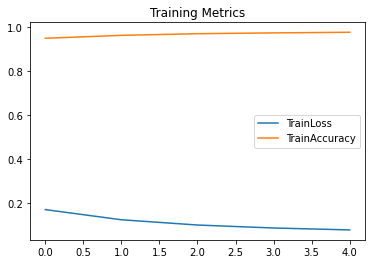

In [26]:
# loss result
plt.plot(model.loss, label = 'TrainLoss')
plt.plot(model.accuracy, label = 'TrainAccuracy')
plt.title('Training Metrics')
plt.legend()
plt.show()